## Example of STM in use
This is different than poliblogs.ipynb because we are demonstrating use of metadata

In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrix
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from py_stm.stmmulticore import StmMulticore
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
poliblogs = pd.read_csv("test_data/poliblogs2008.csv", )
poliblogs = poliblogs.loc[:, ~poliblogs.columns.str.contains('^Unnamed')]

poliblogs.head()

,documents,docname,rating,day,blog
0,"After a week of false statements, lies, and di...",at0800300_1.text,Conservative,3,at
1,I honestly don't know how either party's caucu...,at0800300_2.text,Conservative,3,at
2,While we stand in awe of the willingness of ou...,at0800300_3.text,Conservative,3,at
3,These pages recently said goodbye to global wa...,at0800300_4.text,Conservative,3,at
4,A US report shows how the enemy controlled the...,at0800300_5.text,Conservative,3,at


In [3]:
print(f"There are {len(poliblogs)} many documents in the poliblogs dataset")

There are 13246 many documents in the poliblogs dataset


In [4]:
nltk.download('stopwords')  # Download the stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerholston/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def preprocess_text(text, min_len):
    tokens = simple_preprocess(text, deacc=True, min_len=min_len)  # deacc=True removes punctuation
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    return filtered_tokens


In [6]:
# Split the text and metadata for training
train_text, test_text, train_metadata, test_metadata = train_test_split(
    poliblogs.documents, poliblogs[['rating', 'day', 'blog']], test_size=0.8, random_state=42
)

# Apply the preprocessing function to the text data
processed_train_text = [preprocess_text(text, min_len=3) for text in train_text]
processed_test_text = [preprocess_text(text, min_len=3) for text in test_text]

# Create the training dictionary
dictionary = Dictionary(processed_train_text)

# Filter extremes (remove tokens that appear in less than 10 documents, or more than 50% of the documents)
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Create the training corpus (bag of words representation)
corpus_train = [dictionary.doc2bow(text) for text in processed_train_text]

In [7]:
from scipy.sparse import csr_matrix
corpus_train[190]
doc_idx, word_idx, count = [], [], []

for i, doc in enumerate(corpus_train):
	for word, freq in doc:
		doc_idx.append(i)
		word_idx.append(word)
		count.append(freq)

a = csr_matrix((count, (doc_idx, word_idx)))

wprob = np.sum(a, axis=0)
wprob = wprob / np.sum(wprob)    
wprob = np.array(wprob)

wprob.flatten()

array([3.46802029e-04, 2.93869088e-04, 7.97644667e-04, ...,
       2.00780122e-05, 2.19032860e-05, 2.55538337e-05])

In [8]:
# A user could precompute the prevalence themselves like so
from patsy import dmatrix

# prevalence = dmatrix("~rating+cr(day, df=3)", data=train_metadata, return_type='dataframe')
prevalence = dmatrix("~rating+blog", data=train_metadata, return_type='dataframe')
a = prevalence.astype("category")
prevalence

,Intercept,rating[T.Liberal],blog[T.db],blog[T.ha],blog[T.mm],blog[T.tp],blog[T.tpm]
11708,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7650,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8599,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7788,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3456,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
11964,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5191,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5390,1.0,0.0,0.0,1.0,0.0,0.0,0.0
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Train the STM model
num_topics = 5  # Define the number of topics you want to extract

# PREVALENCE MODEL
stm = StmMulticore(corpus_train, num_topics=num_topics, id2word=dictionary, prevalence=prevalence, passes=10, random_state=420, chunksize=500) # intended use 1. prevalence matrix precomputed

# CONTENT MODEL
#stm = StmMulticore(corpus_train, num_topics=num_topics, id2word=dictionary, metadata=train_metadata, content=train_metadata.loc[:, "rating"], passes=10, random_state=420, chunksize=500) # intended use 3. metadata dataframe and content formula

# BOTH MODEL
#stm = StmMulticore(corpus_train, num_topics=num_topics, id2word=dictionary, prevalence=prevalence, content=train_metadata.loc[:, "rating"], passes=5, random_state=420, chunksize=500)

/Users/tylerholston/Desktop/stm/env3/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
PASS 0, 2649
/Users/tylerholston/Desktop/stm/py_stm/stm.py:1134: DeprecationWarning: invalid escape sequence '\i'
  """Label topics


KeyboardInterrupt: 

In [ ]:
stm.label_topics(range(0,5), n=20, print_labels=True)

Topic 0:
 	 Highest Prob: ['mccain', 'john', 'said', 'palin', 'think', 'today', 'sen', 'going', 'update', 'economy', 'states', 'fact', 'say', 'point', 'support', 'policy', 'bill', 'biden', 'crisis', 'republican']
Topic 0:
 	 FREX: ['mccain', 'john', 'sen', 'economy', 'romney', 'rally', 'biden', 'palin', 'lieberman', 'georgia', 'maverick', 'virginia', 'sarah', 'voted', 'fox', 'error', 'http', 'arizona', 'veterans', 'debate']
Topic 1:
 	 Highest Prob: ['bush', 'iraq', 'government', 'house', 'administration', 'war', 'security', 'white', 'congress', 'iran', 'military', 'plan', 'iraqi', 'george', 'intelligence', 'troops', 'officials', 'department', 'nuclear', 'yesterday']
Topic 1:
 	 FREX: ['bush', 'administration', 'iraqi', 'torture', 'sadr', 'agreement', 'intelligence', 'rice', 'petraeus', 'perino', 'iraqis', 'maliki', 'iran', 'nuclear', 'iraq', 'department', 'paulson', 'george', 'weapons', 'saddam']
Topic 2:
 	 Highest Prob: ['president', 'said', 'people', 'american', 'world', 'years', '

([['mccain',
   'john',
   'said',
   'palin',
   'think',
   'today',
   'sen',
   'going',
   'update',
   'economy',
   'states',
   'fact',
   'say',
   'point',
   'support',
   'policy',
   'bill',
   'biden',
   'crisis',
   'republican'],
  ['bush',
   'iraq',
   'government',
   'house',
   'administration',
   'war',
   'security',
   'white',
   'congress',
   'iran',
   'military',
   'plan',
   'iraqi',
   'george',
   'intelligence',
   'troops',
   'officials',
   'department',
   'nuclear',
   'yesterday'],
  ['president',
   'said',
   'people',
   'american',
   'world',
   'years',
   'like',
   'united',
   'country',
   'america',
   'time',
   'new',
   'also',
   'israel',
   'many',
   'right',
   'law',
   'report',
   'know',
   'year'],
  ['campaign',
   'new',
   'people',
   'like',
   'said',
   'barack',
   'get',
   'time',
   'political',
   'times',
   'know',
   'last',
   'also',
   'make',
   'made',
   'years',
   'senator',
   'well',
   'media',


In [ ]:
topics = [1, 2, 3] # or range(1, 4)
for topic, docs in zip(topics, stm.find_thoughts(topics, n=6)):
    print(f"Topic: {topic}")
    print(poliblogs.iloc[docs]['documents'])
    print("\n")

Topic: 1
2274    The Republican party is making a comeback in t...
1165    Before becoming a US Senator, Barack Obama spe...
1600    The Democratic Party has announced that Barack...
1925    Stephen Hayes of the Weekly Standard has the s...
1440    A sure sign of the weakening power of Moqtada ...
1956    These days, it seems that celebrities of all s...
Name: documents, dtype: object


Topic: 2
1660    I suppose I should by now be inured to the new...
2178    One can take the conclusions reached in this s...
1946    What makes these statements by Howard Dean so ...
2465    What is it with the legacy media? Don't they k...
1879    Memphis, Tennessee had a primary yesterday and...
930     There is some Interesting circumstantial evide...
Name: documents, dtype: object


Topic: 3
219     Defying the expectations of the pundits, John ...
1451    Barack Obama is against lifting the ban on dri...
1487    You have to wonder what will be going through ...
1247    Making it clear that she will

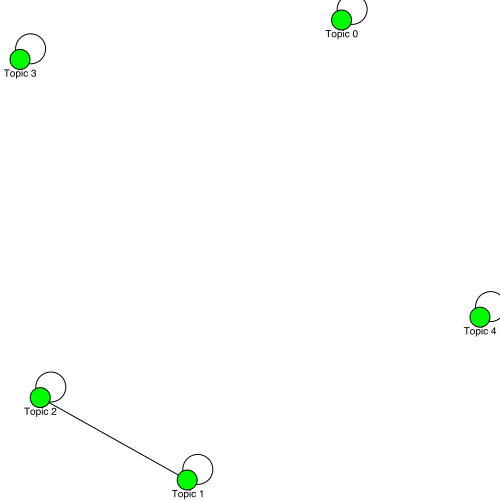

In [ ]:
stm.printTopTopics("topicCorr.png", topics=np.array([0, 1, 2, 3, 4]), bbox=(0,0,500,500))

In [ ]:
import pyLDAvis
pyLDAvis.enable_notebook()
vis_accommodations = pyLDAvis.gensim_models.prepare(stm, corpus_train, stm.id2word, mds="mmds")
# vis_accommodations.save('visualizations/poliblogs.html') Saving doesn't work right now
vis_accommodations

/Users/tylerholston/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.067048 -0.160765       1        1  23.365036
3     -0.022578 -0.096450       2        1  22.951842
4     -0.111753 -0.175876       3        1  20.943875
0     -0.225424  0.167260       4        1  18.331313
1      0.292707  0.265831       5        1  14.407934, topic_info=           Term         Freq        Total Category  logprob  loglift
184      mccain  5285.000000  5285.000000  Default  30.0000  30.0000
297        bush  2253.000000  2253.000000  Default  29.0000  29.0000
9      campaign  2192.000000  2192.000000  Default  28.0000  28.0000
1349       iraq  1758.000000  1758.000000  Default  27.0000  27.0000
58    president  1928.000000  1928.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1507    general   290.748608   518.965095   Topic5  -5.6039   1.3580
483         tax   304.133988   600.842058   Topic5  -5.5589   1.2565
187       money   300.044846   707.657000   Topic5  -5.5725   1.0794
1171      since   299.073442   746.195313   Topic5  -5.5757   1.0231
188      months   270.275406   474.497352   Topic5  -5.6769   1.3746

[429 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3763      1  1.000841      abbas
2980      4  0.995409   abramoff
3457      1  0.038166      acorn
3457      2  0.877810      acorn
3457      3  0.089053      acorn
...     ...       ...        ...
285       5  0.490556  yesterday
1962      4  1.010971   yglesias
761       1  0.213722       york
761       2  0.692459       york
761       3  0.091900       york

[924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])